In [460]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 25)
from scipy.stats import chi2_contingency


#### Biodiversity Project

This project will analyze data from two files: observations.csv and species_info.csv

`Observations.csv` compiles information about the scientific names of a species, the number of observations of that species in the past 7 days, and the park where the observations occurred. Variables:
- **scientific_name**
- **park_name**
- **observations**

`Species_info.csv` compiles information about all the different scientific names for species, the common names for these species, the category of the species, and the conservation status of the species. Variables:
- **category**
- **scientific_name**
- **common_names**
- **conservation_status**



In [39]:
species = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/species_info.csv')
print(f'Shape of species: {species.shape}')
species.fillna(value = {'conservation_status': 'no intervention'}, inplace=True)
species.head()
# category
# scientific_name
# common_names
# conservation_status



Shape of species: (5824, 4)


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,no intervention
1,Mammal,Bos bison,"American Bison, Bison",no intervention
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",no intervention
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",no intervention
4,Mammal,Cervus elaphus,Wapiti Or Elk,no intervention


In [12]:
observations = pd.read_csv('/users/ghanimsial/desktop/Code Cademy/Data Science Machine Learning Specialist/Biodiversity Project/observations.csv')
print(f'Shape of observations: {observations.shape}')
observations.head()
# scientific_name
# park_name
# observations

Shape of observations: (23296, 3)


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


#### Objectives
- **Distribution of conservation_status across category**
- **Are certain types of species more likely to be endangered as compared to others?**
- **Which animal is comprised of the greatest number of species and what is its observations distribution across parks?**
- **Are the differences between species and their conservation status significant?**


[Text(0, 0, 'Mammal'),
 Text(1, 0, 'Bird'),
 Text(2, 0, 'Reptile'),
 Text(3, 0, 'Amphibian'),
 Text(4, 0, 'Fish'),
 Text(5, 0, 'Vascular Plant'),
 Text(6, 0, 'Nonvascular Plant')]

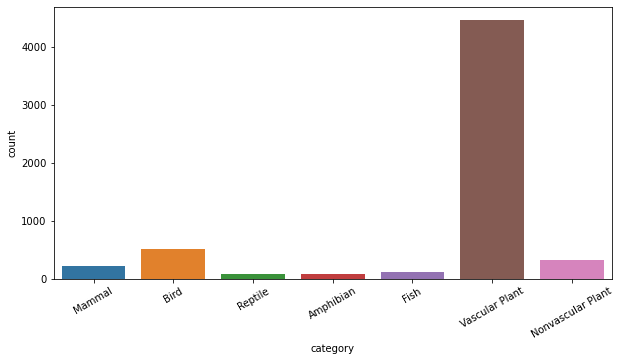

In [38]:
species.conservation_status.unique()
plt.figure(figsize = (10,5))
ax = sns.countplot(data = species, x = species.category)
ax.set_xticklabels(labels = species.category.unique(), rotation = 30)

5541

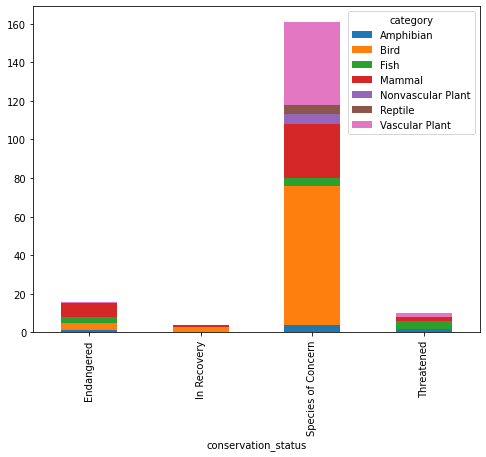

In [58]:
cat_cons = species[species['conservation_status'] != 'no intervention'].groupby(['conservation_status', 'category']).scientific_name.count().unstack()
cat_cons.plot(kind = 'bar', stacked = True, figsize = (8,6))


In [118]:
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts.columns = ['category', 'not protected', 'protected']
category_counts['protection_percentage'] = np.round(100*category_counts.protected/(category_counts['not protected']+category_counts.protected), 2)
category_counts


,category,not protected,protected,protection_percentage
0,Amphibian,72,7,8.86
1,Bird,413,75,15.37
2,Fish,115,11,8.73
3,Mammal,146,30,17.05
4,Nonvascular Plant,328,5,1.50
5,Reptile,73,5,6.41
6,Vascular Plant,4216,46,1.08


In [149]:
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts1 = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts1.columns = ['category', 'not protected', 'protected']
mammal_bird = [[30, 146], [75, 413]]
results = chi2_contingency(mammal_bird)
print(f'Mammals Vs. Birds\nP-Value: {results[1]} \nChi Statistic:{results[0]}')
# The p-value is statistically insignificant suggesting the two variables are independent
#The chi squared statistic is also small suggesting no associativity.



Mammals Vs. Birds
P-Value: 0.6875948096661336 
Chi Statistic:0.1617014831654557


In [153]:
species['is_protected'] = species['conservation_status'] != 'no intervention'
category_counts2 = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns = 'is_protected', index = 'category', values = 'scientific_name').reset_index()
category_counts2.columns = ['category', 'not protected', 'protected']
reptile_mammal = [[5, 73], [30, 146]]
results = chi2_contingency(reptile_mammal)
print(results)
print(f'Reptile vs. Mammal\nP-Value: {results[1]} \nChi Statistic:{results[0]}')
#The P-value is statistically significant at the 5% level and a chi statistic of 4.28 suggest associativity meaning that mammals are statistically more likely to need protection as compared to reptiles.

(4.289183096203645, 0.03835559022969898, 1, array([[ 10.7480315,  67.2519685],
       [ 24.2519685, 151.7480315]]))
Reptile vs. Mammal
P-Value: 0.03835559022969898 
Chi Statistic:4.289183096203645


In [419]:
data = species[species.category == 'Mammal']
punctuation = [',', "'", '(', ')', '.', '-']
def remove_punctuation(text):
    for i in punctuation:
        text = text.replace(i, '')
    return text
empty_dict = {}
empty_list = []

data.common_names = data.common_names.apply(remove_punctuation)
for i in data.common_names:
    i = i.split()
    i = list(dict.fromkeys(i))
    for y in i:
        if y in empty_dict:
            empty_dict[y] +=1
        else:
            empty_dict[y] = 1
listy = list(zip(empty_dict.keys(), empty_dict.values()))
listy = pd.DataFrame(listy)
listy.sort_values(by = 1, ascending = False)

/var/folders/cn/qrzvtdnd3wg0270pcwylrl5m0000gn/T/ipykernel_58304/2995702985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.common_names = data.common_names.apply(remove_punctuation)


,0,1
51,Bat,23
110,Shrew,18
57,Myotis,17
88,Mouse,16
107,Chipmunk,13
3,American,12
105,Squirrel,12
37,Eastern,11
2,Vole,11
29,Mountain,10


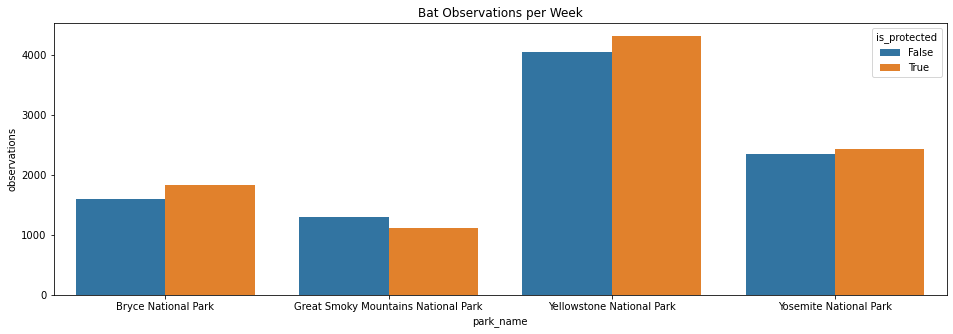

In [452]:
species['is_bat'] = species.common_names.str.contains(r'\bBat\b', regex = True)
bat_observations = species[species.is_bat == True]
bat_observations = bat_observations.merge(observations, on = 'scientific_name')
bat_prot_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
bat_prot_by_park.columns = ['park_name', 'is_protected', 'observations']
plt.figure(figsize = (16,5))
sns.barplot(data = bat_prot_by_park, x = 'park_name', y = 'observations', hue = 'is_protected')
plt.title('Bat Observations per Week')
plt.show()


In [470]:
merger = observations.merge(species, on = 'scientific_name')
protected = merger[merger.is_protected == True]

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
122,Zizia trifoliata,Bryce National Park,87,Vascular Plant,"Meadow Alexanders, Three-Leaved Golden Alexanders",Species of Concern,True,False
204,Camissonia sierrae ssp. alticola,Bryce National Park,84,Vascular Plant,"Mono Hot Springs Evening Primrose, Mono Hot Sp...",Species of Concern,True,False
378,Tofieldia glabra,Bryce National Park,70,Vascular Plant,"Smooth Bog-Asphodel, Smooth Tofieldia",Species of Concern,True,False
512,Accipiter cooperii,Bryce National Park,95,Bird,Cooper's Hawk,Species of Concern,True,False
622,Dichanthelium acuminatum var. acuminatum,Bryce National Park,87,Vascular Plant,Tapered Rosette Grass,Species of Concern,True,False
...,...,...,...,...,...,...,...,...
24749,Sorex preblei,Bryce National Park,71,Mammal,"Malheur Shrew, Preble's Shrew",Species of Concern,True,False
24901,Chlidonias niger,Bryce National Park,105,Bird,Black Tern,Species of Concern,True,False
24970,Progne subis,Bryce National Park,82,Bird,Purple Martin,Species of Concern,True,False
25270,Lophocolea appalachiana,Bryce National Park,81,Nonvascular Plant,Appalachian Lophocolea,Species of Concern,True,False
